In [1]:
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/nick/python/ASoP_global/ASoP-Coherence')
sys.path.append('/home/nick/python/my-analysis/semantics')
from asop_coherence_global import get_asop_dict
from semantics import ensure_bounds
import matplotlib.cm as mpl_cm
import numpy as np
import numpy.ma as ma
import pandas as pd
import skill_metrics as sm

In [2]:
def load_all_summary_metrics(asop_dict,wet_season_threshold='1d24'):
    constraints_longnames_units = [
        ('spatial intermittency on-off metric based on 4 divisions (weighted mean of all months in wet season)','spatial coh metric, 4divs, wet seas','1'),
        ('Probability of upper division neighbouring upper division (weighted mean of all months in wet season)','p(on|on), 4divs, wet seas','1'),
        ('Probability of upper division neighbouring lower division (weighted mean of all months in wet season)','p(on|off), 4divs, wet seas','1'),
        ('Probability of lower division neighbouring upper division (weighted mean of all months in wet season)','p(off|on), 4divs, wet seas','1'),
        ('Probability of lower division neighbouring lower division (weighted mean of all months in wet season)','p(off|off), 4divs, wet seas','1')
    ]
    out_cubelist = []
    summary_file = asop_dict['desc']+'_asop_'+asop_dict['year_range']+'_spatial_summary_wetseason'+wet_season_threshold+'.nc'
    for constraint,long_name,units in constraints_longnames_units:
        print(constraint)
        cube = load_summary_metric(str(asop_dict['dir']/summary_file),constraint,long_name,units)
        out_cubelist.append(cube)
    return(out_cubelist)

def load_summary_metric(filename,constraint,new_long_name,new_units):
    cube = iris.load_cube(filename,constraint)
    cube.long_name = new_long_name
    cube.units = new_units
    return(cube)

In [3]:
def find_distcorr_threshold(cube,threshold=0.5,long_name=None,units=None):
    import numpy as np
    #max_autocorr = cube.collapsed('lag',iris.analysis.MEAN).copy()
    lon = cube.coord('longitude')
    lat = cube.coord('latitude')
    dist = cube.coord('distance')
    nlon = len(lon.points)
    nlat = len(lat.points)
#    max_autocorr = iris.cube.Cube(np.ma.empty((nlat,nlon)),dim_coords_and_dims=[(lat,0),(lon,1)])
    max_autocorr = np.zeros((nlat,nlon))
    print(cube)
    for y in range(nlat):
        for x in range(nlon):
            below_threshold = np.where(cube.data[:,y,x] <= threshold)
            if np.sum(below_threshold) >= 1:
                max_autocorr[y,x] = dist.points[np.amin(below_threshold)]-1
            else:
                max_autocorr[y,x] = np.nan #np.amax(dist.points)
    max_autocorr_cube = iris.cube.Cube(data=max_autocorr,dim_coords_and_dims=[(lat,0),(lon,1)],long_name=long_name,units=units,var_name='distcorr_threshold'+str(threshold))
    return(max_autocorr_cube)

def mask_model_by_gpm(model_cube,gpm_cube):
    model_mask = np.isnan(model_cube.data)
    gpm_mask = np.isnan(gpm_cube.data)
    my_mask = np.ma.mask_or(model_mask,gpm_mask)
    new_cube = model_cube.copy(data=np.ma.masked_array(model_cube.data,my_mask))
    return(new_cube)

In [4]:
def compute_summary_stats(model_cube,obs_cube,region,region_type,region_name,diag_name,model_dict,mask=None):
    import pandas as pd
    # Average space-time summary metrics over a given region.
    # Mask for land-only if requested.
    import iris.analysis.stats as istats
    grid_constraint = iris.Constraint(latitude=lambda cell: region[0] <= cell <= region[1],
                                      longitude=lambda cell: region[2] <= cell <= region[3])
    model_region = model_cube.extract(grid_constraint)
    obs_region = obs_cube.extract(grid_constraint)
    if region_type == 'land' or region_type == 'ocean':
        if mask is None:
            raise Exception('Computing summary stats over '+region_type+' requires a mask, but mask is None.')
        model_cube = ensure_bounds(model_cube,['latitude','longitude'])
        obs_cube = ensure_bounds(obs_cube,['latitude','longitude'])
        mask = ensure_bounds(mask,['latitude','longitude'])
        mask_regrid = mask.regrid(model_region,iris.analysis.AreaWeighted())
        mask_region = mask_regrid.extract(grid_constraint)
        print(mask_region)
        print(mask_region.data)
        if region_type == 'land':
            model_region = model_region.copy(data=np.ma.array(model_region.data,mask=np.where(mask_region.data >= 0.5,False,True)))
            obs_region = obs_region.copy(data=np.ma.array(obs_region.data,mask=np.where(mask_region.data >= 0.5,False,True)))
        if region_type == 'ocean':
            model_region = model_region.copy(data=np.ma.array(model_region.data,mask=np.where(mask_region.data < 0.5,False,True)))
            obs_region = obs_region.copy(data=np.ma.array(obs_region.data,mask=np.where(mask_region.data < 0.5,False,True)))
    weights = iris.analysis.cartography.area_weights(model_region)
    model_avg = model_region.collapsed(['longitude','latitude'],iris.analysis.MEAN,weights=weights)
    obs_avg = obs_region.collapsed(['longitude','latitude'],iris.analysis.MEAN,weights=weights)
    
    diff = model_region-obs_region
    bias = diff.collapsed(('longitude','latitude'),iris.analysis.MEAN,weights=weights)
    rmse = diff.collapsed(('longitude','latitude'),iris.analysis.RMS,weights=weights)
    std = model_region.collapsed(('longitude','latitude'),iris.analysis.STD_DEV)
    pcorr = istats.pearsonr(model_region,obs_region,weights=weights,common_mask=True) #,corr_coords=('latitude','longitude'))
    npcorr = np.corrcoef(model_region.data.flatten(),obs_region.data.flatten())[0,1]
    print(npcorr)
    #ts = sm.taylor_statistics(model_region.data.flatten(),obs_region.data.flatten(),'data')
    ts = [std.data,rmse.data,pcorr.data,bias.data]
    print(ts)
    return(ts)

In [17]:
threshold = 0.2
time_type='3hr'
if time_type == 'day':
    models=['GPM_IMERG','BCC','AWI','CanESM5','ACCESS','CESM2','CMCC','CNRM','FGOALS','GFDL','HadGEM3','INM','IPSL','KACE','MIROC','MPI','MRI','NESM','NorESM','SAM0-UNICON','TaiESM','UKESM1']
elif time_type == '3hr':
    models=['GPM_IMERG','AWI','BCC','ACCESS','CMCC','CNRM','FGOALS','KACE','MRI','SAM0-UNICON']
grid_type='2x2'
nmodels = len(models)
units='km'

In [6]:
gpm_dict = get_asop_dict('GPM_IMERG',time=time_type,grid=grid_type)
gpm_spatial_summary,gpm_ponon,gpm_ponoff,gpm_poffon,gpm_poffoff = load_all_summary_metrics(gpm_dict)
gpm_autocorr_filename = str(gpm_dict['dir'])+'/'+gpm_dict['desc']+'_asop_'+gpm_dict['year_range']+'_spatial_corr_wetseason1d24.nc'
gpm_autocorr = load_summary_metric(gpm_autocorr_filename,'distance_correlations_mean',None,'km')
gpm_threshold = find_distcorr_threshold(gpm_autocorr,threshold=threshold,long_name='Dist corr, >'+str(threshold)+', wet seas '+gpm_dict['name'],units='km')

GPM_IMERG
spatial intermittency on-off metric based on 4 divisions (weighted mean of all months in wet season)
Probability of upper division neighbouring upper division (weighted mean of all months in wet season)
Probability of upper division neighbouring lower division (weighted mean of all months in wet season)
Probability of lower division neighbouring upper division (weighted mean of all months in wet season)
Probability of lower division neighbouring lower division (weighted mean of all months in wet season)
distance_correlations_mean / (km)   (distance: 5; latitude: 62; longitude: 180)
     Dimension coordinates:
          distance                           x            -              -
          latitude                           -            x              -
          longitude                          -            -              x
     Attributes:
          Conventions: CF-1.7


In [7]:
regions = [
    ([-20,20,0,360],'trop'),
    ([-60,-20,0,360],'sh'),
    ([20,60,0,360],'nh'),
    ([-60,60,0,360],'glob')
]
nregions = len(regions)
mask_file='/media/nick/lacie_tb3/datasets/land_sea_mask/landfrac_n216e_hadgem3-10.3.nc'
mask = iris.load_cube(mask_file,'land_area_fraction')
metrics = pd.DataFrame()

In [18]:
for region,region_name in regions:
    print('--> '+region_name)
    plt.figure(figsize=(8, 6))
    region_types=[
        ('both','off','k'),
        ('land','on','r'),
        ('ocean','on','b')
    ]
    for region_type,overlay,color in region_types:
        print('-->--> '+region_type)
        sdev = np.empty(nmodels) 
        rmsd = np.empty(nmodels)
        corr = np.empty(nmodels)
        bias = np.empty(nmodels)
        for m,model in enumerate(models):
            print('-->-->--> '+model)
            model_dict = get_asop_dict(model,time=time_type,grid=grid_type)
            model_spatial_summary,model_ponon,model_ponoff,model_poffon,model_poffoff = load_all_summary_metrics(model_dict)
            gpm_spatial_summary,gpm_ponon,gpm_ponoff,gpm_poffon,gpm_poffoff = load_all_summary_metrics(gpm_dict)
            ts = compute_summary_stats(model_spatial_summary,gpm_spatial_summary,region,region_type,region_name,'spatial_summary',model_dict,mask=mask)
            sdev[m] = np.array(ts[0])
            rmsd[m] = np.array(ts[1])
            corr[m] = np.array(ts[2])
            bias[m] = np.array(ts[3])        
        sm.taylor_diagram(sdev,rmsd,corr,markerLabel=models,markerLegend='on',markerLabelColor='k',markerColor=color, styleOBS = '-', colOBS = color, markerobs = 'o',markerSize = 8,tickRMSangle = 115, showlabelsRMS = 'on',titleRMS = 'on', titleOBS = 'GPM', checkstats = 'on',overlay=overlay,axismax=0.20,tickrms=[0,0.04,0.08,0.12,0.16,0.20]) 
        #,cmapzdata=bias,titleColorBar='Bias (hours)',markerDisplayed='colorBar')
    plt.savefig('plots/asop_coherence_global_spatial_taylor_'+time_type+'_spatialsummary_'+region_name+'.png',dpi=200)

--> trop
-->--> both
-->-->--> GPM_IMERG
GPM_IMERG
spatial intermittency on-off metric based on 4 divisions (weighted mean of all months in wet season)
Probability of upper division neighbouring upper division (weighted mean of all months in wet season)
Probability of upper division neighbouring lower division (weighted mean of all months in wet season)
Probability of lower division neighbouring upper division (weighted mean of all months in wet season)
Probability of lower division neighbouring lower division (weighted mean of all months in wet season)
spatial intermittency on-off metric based on 4 divisions (weighted mean of all months in wet season)
Probability of upper division neighbouring upper division (weighted mean of all months in wet season)
Probability of upper division neighbouring lower division (weighted mean of all months in wet season)
Probability of lower division neighbouring upper division (weighted mean of all months in wet season)
Probability of lower division nei

KeyboardInterrupt: 

0681
distance_correlations_mean / (km)   (distance: 5; latitude: 62; longitude: 180)
     Dimension coordinates:
          distance                           x            -              -
          latitude                           -            x              -
          longitude                          -            -              x
     Attributes:
          Conventions: CF-1.7
land_area_fraction / (unknown)      (latitude: 62; longitude: 180)
     Dimension coordinates:
          latitude                           x              -
          longitude                          -              x
     Attributes:
          NCO: 4.7.3
          date: 01/01/00
          history: Sun Feb 10 19:55:09 2019: ncatted -a calendar,t,d,, /home/users/npklingaman/datasets/HADGEM3-KPP_ANCIL/landfrac_n216e_hadgem3-10.3.nc
Sun...
          invalid_units: 0-1
          name: field36
          nco_openmp_thread_number: 1
          source: Unified Model Output (Vn 9.1):
          time: 00:00
          t

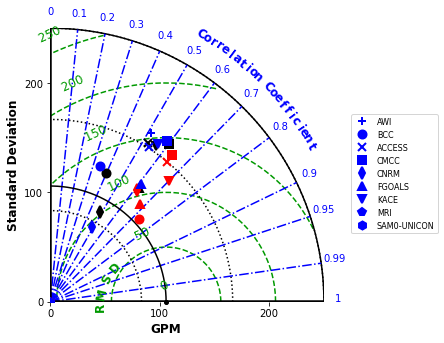

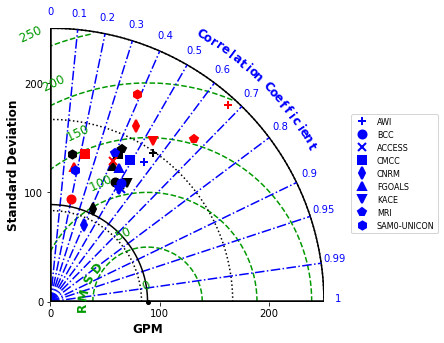

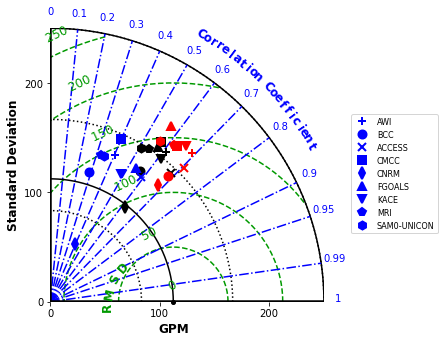

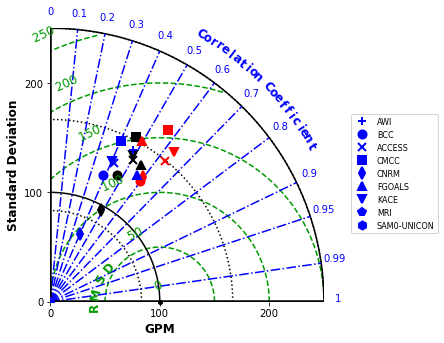

In [24]:
for region,region_name in regions:
    print('--> '+region_name)
    plt.figure(figsize=(8, 6))
    region_types=[
        ('both','off','k'),
        ('land','on','r'),
        ('ocean','on','b')
    ]
    for region_type,overlay,color in region_types:
        print('-->--> '+region_type)
        sdev = np.empty(nmodels) 
        rmsd = np.empty(nmodels)
        corr = np.empty(nmodels)
        bias = np.empty(nmodels)
        for m,model in enumerate(models):
            print('-->-->--> '+model)
            model_dict = get_asop_dict(model,time=time_type,grid=grid_type)
            model_autocorr_filename = str(model_dict['dir'])+'/'+model_dict['desc']+'_asop_'+model_dict['year_range']+'_spatial_corr_wetseason1d24.nc'
            model_autocorr = load_summary_metric(model_autocorr_filename,'distance_correlations_mean',None,units)
            model_autocorr_threshold = find_distcorr_threshold(model_autocorr,threshold=threshold,long_name='Spatial corr >'+str(threshold)+', wet seas '+model_dict['name'],units='km')
            print(model_autocorr_threshold.collapsed(['longitude','latitude'],iris.analysis.MEAN).data)
            gpm_autocorr_filename = str(gpm_dict['dir'])+'/'+gpm_dict['desc']+'_asop_'+gpm_dict['year_range']+'_spatial_corr_wetseason1d24.nc'
            gpm_autocorr = load_summary_metric(gpm_autocorr_filename,'distance_correlations_mean',None,units)
            gpm_autocorr_threshold = find_distcorr_threshold(gpm_autocorr,threshold=threshold,long_name='Spatial corr >'+str(threshold)+', wet seas',units='km')
            ts = compute_summary_stats(model_autocorr_threshold,gpm_autocorr_threshold,region,region_type,region_name,'spatialcorr_threshold'+str(threshold),model_dict,mask=mask)
            sdev[m] = np.array(ts[0])
            rmsd[m] = np.array(ts[1])
            corr[m] = np.array(ts[2])
            bias[m] = np.array(ts[3])        
        sm.taylor_diagram(sdev,rmsd,corr,markerLabel=models,markerLegend='on',markerLabelColor='k',markerColor=color, styleOBS = '-', colOBS = color, markerobs = 'o',markerSize = 8,tickRMSangle = 115, showlabelsRMS = 'on',titleRMS = 'on', titleOBS = 'GPM', checkstats = 'on',overlay=overlay,axismax=250,tickrms=[0,50,100,150,200,250]) 
        #,cmapzdata=bias,titleColorBar='Bias (hours)',markerDisplayed='colorBar')
    plt.savefig('plots/asop_coherence_global_spatial_taylor_'+time_type+'_distcorr'+str(threshold)+'_'+region_name+'.png',dpi=200)